In [13]:
#libraries
import pandas as pd
import numpy as np
#import yfinance as yf
from datetime import datetime, timedelta
import ta
from backtesting import Backtest, Strategy
from backtesting.lib import crossover , barssince
from backtesting.lib import resample_apply
from backtesting import set_bokeh_output
set_bokeh_output(notebook=False)
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tabulate import tabulate
import plotly.express as px
from matplotlib.colors import Normalize
import matplotlib.cm as cm


In [ ]:

# Fetching OHLCV data
file_path_ohlcv = r'D:\matin\code\vscode\.venv\BTCUSDT-5m-2024-04-12.csv'
ohdf = pd.read_csv(file_path_ohlcv)
ohdf['open_time'] = pd.to_datetime(ohdf['open_time'], unit='ms')

rename_dict = {
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume',
}

ohdf.rename(columns=rename_dict, inplace=True)
ohdf.set_index('open_time', inplace=True)
ohdftemp = ohdf.resample('30min').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

# Fetching trades data and backtesting
ohlcv = pd.DataFrame()
carry_over_chunk = pd.DataFrame()
bins = 10
chunksize = 1000000
first_chunk = True
file_path_trades = r'D:\matin\code\vscode\.venv\BTCUSDT-trades-2024-04-12.csv'

for chunk in pd.read_csv(file_path_trades, chunksize=chunksize):
    chunk['time'] = pd.to_datetime(chunk['time'], unit='ms')
    chunk = pd.concat([carry_over_chunk, chunk])
    start_time = chunk['time'].min()
    end_time = chunk['time'].max()
    shifted_start_time = start_time.floor('30T')
    shifted_end_time = end_time.floor('30T')
    '''
    if first_chunk:  
        shifted_start_time = start_time #- timedelta(minutes=30)
        shifted_end_time = end_time #- timedelta(minutes=30)
        first_chunk = False  
    else:
        shifted_start_time = start_time
        shifted_end_time = end_time
    '''
    
    ohlcv_chunk = ohdftemp[(ohdftemp.index >= shifted_start_time) & (ohdftemp.index <= shifted_end_time)]
    carry_over_chunk = chunk[chunk['time'] > shifted_end_time]

    scale = 30  # minutes
    trades = []

    time_diff_minutes = int((shifted_end_time - shifted_start_time + timedelta(minutes=30)).total_seconds() / 60)
    for i in range(0, time_diff_minutes, scale):
        start_interval = shifted_start_time + timedelta(minutes=i)
        end_interval = start_interval + timedelta(minutes=scale)
        tempdf = chunk[(chunk['time'] >= start_interval) & (chunk['time'] <= end_interval)]
        trades.append(tempdf.copy())

    limitrate = []
    makerbv = []
    makersv = []
    makerb = []
    makers = []
    makerbuyprices = []
    makersellprices = []
    makerbuypricevol = []
    makersellpricevol = []
    makerbuypricegt1 = []
    makersellpricegt1 = []
    makerbuypricevolgt1 = []
    makersellpricevolgt1 = []

    for trade_df in trades:
        if not trade_df.empty:
            makerbdf = trade_df[trade_df['is_buyer_maker'] == True]
            makersdf = trade_df[trade_df['is_buyer_maker'] == False]
            makersum = makerbdf['qty'].sum()
            takersum = makersdf['qty'].sum()
            makerbuynum = makerbdf.shape[0]
            makersellnum = makersdf.shape[0]
            ratio = takersum / makersum if makersum > 0 else float('inf')

            price_bins_b = np.linspace(makerbdf['price'].min(), makerbdf['price'].max(), bins + 1)
            price_bins_s = np.linspace(makersdf['price'].min(), makersdf['price'].max(), bins + 1)

            makerbdf['price_bin'] = pd.cut(makerbdf['price'], bins=price_bins_b, include_lowest=True )
            volume_by_bin_b = makerbdf.groupby('price_bin')['qty'].sum()
            max_volume_bin_b = volume_by_bin_b.idxmax()
            max_volume_b = volume_by_bin_b.max()
            bprice = max_volume_bin_b.right

            makersdf['price_bin'] = pd.cut(makersdf['price'], bins=price_bins_s, include_lowest=True)
            volume_by_bin_s = makersdf.groupby('price_bin')['qty'].sum()
            max_volume_bin_s = volume_by_bin_s.idxmax()
            max_volume_s = volume_by_bin_s.max() 
            sprice = max_volume_bin_s.right

            # Filtering trades with volume greater than 1 BTC
            makerbdf_gt1 = makerbdf[makerbdf['qty'] > 1]
            makersdf_gt1 = makersdf[makersdf['qty'] > 1]

            # Find max volume bin for trades > 1 BTC
            if not makerbdf_gt1.empty:
                makerbdf_gt1['price_bin'] = pd.cut(makerbdf_gt1['price'], bins=price_bins_b, include_lowest=True)
                volume_by_bin_b_gt1 = makerbdf_gt1.groupby('price_bin')['qty'].sum()
                max_volume_bin_b_gt1 = volume_by_bin_b_gt1.idxmax()
                max_volume_b_gt1 = volume_by_bin_b_gt1.max()
                bprice_gt1 = max_volume_bin_b_gt1.right
            else:
                max_volume_b_gt1 = 0
                bprice_gt1 = 0

            if not makersdf_gt1.empty:
                makersdf_gt1['price_bin'] = pd.cut(makersdf_gt1['price'], bins=price_bins_s, include_lowest=True)
                volume_by_bin_s_gt1 = makersdf_gt1.groupby('price_bin')['qty'].sum()
                max_volume_bin_s_gt1 = volume_by_bin_s_gt1.idxmax()
                max_volume_s_gt1 = volume_by_bin_s_gt1.max()
                sprice_gt1 = max_volume_bin_s_gt1.right
            else:
                max_volume_s_gt1 = 0
                sprice_gt1 = 0
        else:
            ratio = 0
            makersum = 0
            takersum = 0
            makerbuynum = 0
            makersellnum = 0
            max_volume_b = 0
            bprice = 0

        limitrate.append(ratio)
        makerbv.append(makersum)
        makersv.append(takersum)
        makerb.append(makerbuynum)
        makers.append(makersellnum)
        makerbuyprices.append(bprice)
        makersellprices.append(sprice)
        makerbuypricevol.append(max_volume_b)
        makersellpricevol.append(max_volume_s)
        makerbuypricegt1.append(bprice_gt1)
        makersellpricegt1.append(sprice_gt1)
        makerbuypricevolgt1.append(max_volume_b_gt1)
        makersellpricevolgt1.append(max_volume_s_gt1)
    
    ohlcv_chunk['limit_rate'] = limitrate
    ohlcv_chunk['maker_buy_num_total'] = makerb
    ohlcv_chunk['maker_buy_volume_total'] = makerbv
    ohlcv_chunk['maker_sell_num_total'] = makers
    ohlcv_chunk['maker_sell_volume_total'] = makersv
    ohlcv_chunk['maker_buy_price'] = makerbuyprices
    ohlcv_chunk['maker_sell_price'] = makersellprices
    ohlcv_chunk['maker_buy_price_volume'] = makerbuypricevol
    ohlcv_chunk['maker_sell_price_volume'] = makersellpricevol
    ohlcv_chunk['maker_buy_price_gt1'] = makerbuypricegt1
    ohlcv_chunk['maker_sell_price_gt1'] = makersellpricegt1
    ohlcv_chunk['maker_buy_price_volume_gt1'] = makerbuypricevolgt1
    ohlcv_chunk['maker_sell_price_volume_gt1'] = makersellpricevolgt1

    ohlcv = pd.concat([ohlcv, ohlcv_chunk])
    print(1)

ohlcv[['maker_buy_price', 'maker_sell_price', 'maker_buy_price_volume', 
       'maker_sell_price_volume', 'maker_buy_price_gt1', 'maker_sell_price_gt1',
       'maker_buy_price_volume_gt1', 'maker_sell_price_volume_gt1' ]] = ohlcv[['maker_buy_price',
       'maker_sell_price', 'maker_buy_price_volume', 
       'maker_sell_price_volume', 'maker_buy_price_gt1', 'maker_sell_price_gt1',
       'maker_buy_price_volume_gt1', 'maker_sell_price_volume_gt1' ]].shift(1).fillna(method='bfill')

# Reset index to have a proper datetime index
#ohlcv = ohlcv.reset_index().set_index('open_time')



In [28]:
print(ohlcv[0:3])

                        Open     High      Low    Close    Volume  limit_rate  \
open_time                                                                       
2024-04-12 00:00:00  70055.6  70384.3  70044.4  70316.5  2691.418    1.216542   
2024-04-12 00:30:00  70316.6  70380.0  70270.5  70342.0  1448.935    0.914013   
2024-04-12 01:00:00  70342.0  70421.7  70195.8  70222.3  1533.258    0.722123   

                     maker_buy_num_total  maker_buy_volume_total  \
open_time                                                          
2024-04-12 00:00:00                26090                1214.242   
2024-04-12 00:30:00                19998                 757.014   
2024-04-12 01:00:00                23099                 890.330   

                     maker_sell_num_total  maker_sell_volume_total  \
open_time                                                            
2024-04-12 00:00:00                 30132                 1477.176   
2024-04-12 00:30:00                 18953  

In [5]:
#fetching datah.
file_path = r'D:\matin\code\vscode\.venv\BTCUSDT-5m-2024-04-12.csv'
ohdf = pd.read_csv(file_path)
ohdf['open_time'] = pd.to_datetime(ohdf['open_time'] , unit='ms')
#df.reset_index(inplace=True)
'''
df.set_index('Open time', inplace=True)
df.index.name = 'Date'
factor = 100000
df['Open'] /= factor
df['High'] /= factor
df['Low'] /= factor
df['Close'] /= factor
df['Open'] = df['Open'].fillna(method='ffill')
df['High'] = df['High'].fillna(method='ffill')
df['Low'] = df['Low'].fillna(method='ffill')
df['Close'] = df['Close'].fillna(method='ffill')
df['Volume'] = df['Volume'].fillna(method='ffill')
'''
rename_dict = {
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume',
}

ohdf.rename(columns=rename_dict, inplace=True)
ohdf.set_index('open_time', inplace=True)
ohdftemp = ohdf.resample('30min').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

print(ohdftemp)


                        Open     High      Low    Close     Volume
open_time                                                         
2024-04-12 00:00:00  70055.6  70384.3  70044.4  70316.5   2691.418
2024-04-12 00:30:00  70316.6  70380.0  70270.5  70342.0   1448.935
2024-04-12 01:00:00  70342.0  70421.7  70195.8  70222.3   1533.258
2024-04-12 01:30:00  70222.4  70375.0  70153.3  70330.1   1542.339
2024-04-12 02:00:00  70330.0  70841.7  70249.3  70749.7   5963.130
2024-04-12 02:30:00  70749.7  70831.6  70659.5  70681.0   3042.537
2024-04-12 03:00:00  70681.0  71037.3  70681.0  70992.9   7595.537
2024-04-12 03:30:00  70992.8  71071.4  70835.6  71034.3   4955.368
2024-04-12 04:00:00  71034.3  71069.3  70889.8  70890.2   2607.981
2024-04-12 04:30:00  70890.2  71297.0  70866.1  71162.8   4902.192
2024-04-12 05:00:00  71162.9  71225.7  70971.1  71086.9   3395.170
2024-04-12 05:30:00  71087.0  71110.0  70948.0  71009.8   2006.428
2024-04-12 06:00:00  71009.8  71069.1  70742.0  70861.9   2943

In [6]:
#fetching datah.
file_path = r'D:\matin\code\vscode\.venv\BTCUSDT-trades-2024-04-12.csv'
tdf = pd.read_csv(file_path)
#tdf['time'] = pd.to_datetime(tdf['time'] , unit='ms')
#df.reset_index(inplace=True)
'''
df.set_index('Open time', inplace=True)
df.index.name = 'Date'
factor = 100000
df['Open'] /= factor
df['High'] /= factor
df['Low'] /= factor
df['Close'] /= factor
df['Open'] = df['Open'].fillna(method='ffill')
df['High'] = df['High'].fillna(method='ffill')
df['Low'] = df['Low'].fillna(method='ffill')
df['Close'] = df['Close'].fillna(method='ffill')
df['Volume'] = df['Volume'].fillna(method='ffill')
'''
tdftemp = tdf.copy()
print(tdftemp)

                 id    price    qty  quote_qty           time  is_buyer_maker
0        4867656092  70055.6  0.044  3082.4464  1712880000085            True
1        4867656093  70055.6  0.002   140.1112  1712880000108            True
2        4867656094  70055.7  0.006   420.3342  1712880000182           False
3        4867656095  70055.7  0.002   140.1114  1712880000182           False
4        4867656096  70055.7  0.002   140.1114  1712880000193           False
...             ...      ...    ...        ...            ...             ...
5589321  4873253419  67136.4  0.013   872.7732  1712966399823            True
5589322  4873253420  67136.4  0.015  1007.0460  1712966399823            True
5589323  4873253421  67136.4  0.013   872.7732  1712966399868            True
5589324  4873253422  67136.4  0.002   134.2728  1712966399868            True
5589325  4873253423  67136.4  0.004   268.5456  1712966399868            True

[5589326 rows x 6 columns]


In [22]:

# sorting trades data
scale = 30  # minutes
dlenth = 1  # day
start_time = 1712880000000
trades = []

for i in range(0, dlenth * 24 * 3600000, scale * 60000):
    start_interval = start_time + i
    end_interval = start_interval + scale * 60000
    tempdf = tdftemp[(tdftemp['time'] >= start_interval) & (tdftemp['time'] < end_interval)]
    trades.append(tempdf.copy())


In [ ]:
for idx, trade_df in enumerate(trades):
    print(f"Trade {idx}:")
    print(trade_df)

In [11]:
mean_volumes = []
ratios = []

for trade_df in trades:
    if not trade_df.empty:
        mean_volume = trade_df['qty'].mean()
        above_mean = trade_df[trade_df['qty'] > 2*mean_volume].shape[0]
        below_mean = trade_df[trade_df['qty'] < 2*mean_volume].shape[0]
        if below_mean == 0:  
            ratio = float('inf') if above_mean > 0 else 0  
        else:
            ratio = above_mean / below_mean
    else:
        mean_volume = 0
        ratio = 0
    
    mean_volumes.append(mean_volume)
    ratios.append(ratio)

ohdftemp['mean_vol'] = mean_volumes
ohdftemp['r'] = ratios

print(ohdftemp)

                        Open     High      Low    Close   Volume  \
2024-04-12 00:00:00  70055.6  70199.8  70044.4  70181.6  442.190   
2024-04-12 00:05:00  70181.6  70260.2  70181.5  70240.0  545.383   
2024-04-12 00:10:00  70240.0  70355.6  70240.0  70277.3  662.132   
2024-04-12 00:15:00  70277.2  70384.3  70277.1  70319.9  413.779   
2024-04-12 00:20:00  70320.0  70324.4  70194.8  70194.8  368.641   
...                      ...      ...      ...      ...      ...   
2024-04-12 23:35:00  67002.9  67131.4  67002.8  67127.0  367.471   
2024-04-12 23:40:00  67126.9  67173.6  67096.9  67138.9  559.421   
2024-04-12 23:45:00  67139.0  67162.9  67104.0  67139.7  391.656   
2024-04-12 23:50:00  67139.7  67261.4  67133.0  67228.2  499.876   
2024-04-12 23:55:00  67228.2  67243.0  67134.3  67136.4  338.332   

                        close_time  quote_volume  count  taker_buy_volume  \
2024-04-12 00:00:00  1712880299999  3.100957e+07   8510           294.552   
2024-04-12 00:05:00  17128805

In [ ]:

bins = 10
limitrate = []
makerbv = []
makersv = []
makerb = []
makers = []
bpricelist = []
spricelist = []
bpricevlist = []
spricevlist = []
bpricelist_gt1 = []
spricelist_gt1 = []
bpricevlist_gt1 = []
spricevlist_gt1 = []

# Assuming 'trades' is a list of DataFrames
for trade_df in trades:
    if not trade_df.empty:
        makerbdf = trade_df[trade_df['is_buyer_maker'] == True]
        makersdf = trade_df[trade_df['is_buyer_maker'] == False]
        makersum = makerbdf['qty'].sum()
        takersum = makersdf['qty'].sum()
        makerbuynum = makerbdf.shape[0]
        makersellnum = makersdf.shape[0]
        if takersum == 0:  
            ratio = float('inf') if makersum > 0 else 0  
        else:
            ratio = takersum / makersum

        price_bins_b = np.linspace(makerbdf['price'].min(), makerbdf['price'].max(), bins + 1)
        price_bins_s = np.linspace(makersdf['price'].min(), makersdf['price'].max(), bins + 1)

        makerbdf['price_bin'] = pd.cut(makerbdf['price'], bins=price_bins_b, include_lowest=True)
        volume_by_bin_b = makerbdf.groupby('price_bin')['qty'].sum()
        max_volume_bin_b = volume_by_bin_b.idxmax()
        max_volume_b = volume_by_bin_b.max()
        bprice = max_volume_bin_b.right

        makersdf['price_bin'] = pd.cut(makersdf['price'], bins=price_bins_s, include_lowest=True)
        volume_by_bin_s = makersdf.groupby('price_bin')['qty'].sum()
        max_volume_bin_s = volume_by_bin_s.idxmax()
        max_volume_s = volume_by_bin_s.max() 
        sprice = max_volume_bin_s.right

        # Filtering trades with volume greater than 1 BTC
        makerbdf_gt1 = makerbdf[makerbdf['qty'] > 1]
        makersdf_gt1 = makersdf[makersdf['qty'] > 1]

        # Find max volume bin for trades > 1 BTC
        if not makerbdf_gt1.empty:
            makerbdf_gt1['price_bin'] = pd.cut(makerbdf_gt1['price'], bins=price_bins_b, include_lowest=True)
            volume_by_bin_b_gt1 = makerbdf_gt1.groupby('price_bin')['qty'].sum()
            max_volume_bin_b_gt1 = volume_by_bin_b_gt1.idxmax()
            max_volume_b_gt1 = volume_by_bin_b_gt1.max()
            bprice_gt1 = max_volume_bin_b_gt1.right
        else:
            max_volume_b_gt1 = 0
            bprice_gt1 = 0

        if not makersdf_gt1.empty:
            makersdf_gt1['price_bin'] = pd.cut(makersdf_gt1['price'], bins=price_bins_s, include_lowest=True)
            volume_by_bin_s_gt1 = makersdf_gt1.groupby('price_bin')['qty'].sum()
            max_volume_bin_s_gt1 = volume_by_bin_s_gt1.idxmax()
            max_volume_s_gt1 = volume_by_bin_s_gt1.max()
            sprice_gt1 = max_volume_bin_s_gt1.right
        else:
            max_volume_s_gt1 = 0
            sprice_gt1 = 0

    else:
        ratio = 0 
        makersum = 0
        takersum = 0
        makerbuynum = 0
        makersellnum = 0
        bprice = 0
        sprice = 0
        max_volume_b = 0
        max_volume_s = 0
        max_volume_b_gt1 = 0
        max_volume_s_gt1 = 0
        bprice_gt1 = 0
        sprice_gt1 = 0

    limitrate.append(ratio)
    makerbv.append(makersum)
    makerb.append(makerbuynum)
    makersv.append(takersum)
    makers.append(makersellnum)

    bpricelist.append(bprice)
    spricelist.append(sprice)
    bpricevlist.append(max_volume_b)
    spricevlist.append(max_volume_s)

    bpricelist_gt1.append(bprice_gt1)
    spricelist_gt1.append(sprice_gt1)
    bpricevlist_gt1.append(max_volume_b_gt1)
    spricevlist_gt1.append(max_volume_s_gt1)

ohdftemp['limit_rate'] = limitrate
ohdftemp['maker_buy_num'] = makerb
ohdftemp['maker_buy_volume'] = makerbv
ohdftemp['maker_sell_num'] = makers
ohdftemp['maker_sell_volume'] = makersv

ohdftemp['maker_buy_price'] = bpricelist
ohdftemp['maker_buy_price_volume'] = bpricevlist
ohdftemp['maker_sell_price'] = spricelist
ohdftemp['maker_sell_price_volume'] = spricevlist

ohdftemp['maker_buy_price_gt1'] = bpricelist_gt1
ohdftemp['maker_buy_price_volume_gt1'] = bpricevlist_gt1
ohdftemp['maker_sell_price_gt1'] = spricelist_gt1
ohdftemp['maker_sell_price_volume_gt1'] = spricevlist_gt1

print(ohdftemp)


In [6]:
print(ohdftemp.head())

                        Open     High      Low    Close    Volume  limit_rate  \
open_time                                                                       
2024-04-12 00:00:00  70055.6  70384.3  70044.4  70316.5  2691.418    1.216542   
2024-04-12 00:30:00  70316.6  70380.0  70270.5  70342.0  1448.935    0.914013   
2024-04-12 01:00:00  70342.0  70421.7  70195.8  70222.3  1533.258    0.722123   
2024-04-12 01:30:00  70222.4  70375.0  70153.3  70330.1  1542.339    1.299829   
2024-04-12 02:00:00  70330.0  70841.7  70249.3  70749.7  5963.130    1.649683   

                     maker_buy_num  maker_buy_volume  maker_sell_num  \
open_time                                                              
2024-04-12 00:00:00          26090          1214.242           30132   
2024-04-12 00:30:00          19998           757.014           18953   
2024-04-12 01:00:00          23099           890.330           18200   
2024-04-12 01:30:00          16530           670.632           19564   


In [11]:
file_path = r'D:\matin\code\vscode\.venv\BTCUSDT-5m-2024-04-12.csv'
ohlcv = pd.read_csv(file_path)
ohlcv['open_time'] = pd.to_datetime(ohlcv['open_time'], unit='ms')
ohlcv.set_index('open_time',inplace= True)

rename_dict = {
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume',
}

ohlcv.rename(columns=rename_dict, inplace=True)
ohlcv['Open'] = ohlcv['Open'].fillna(method='ffill')
ohlcv['High'] = ohlcv['High'].fillna(method='ffill')
ohlcv['Low'] = ohlcv['Low'].fillna(method='ffill')
ohlcv['Close'] = ohlcv['Close'].fillna(method='ffill')
ohlcv['Volume'] = ohlcv['Volume'].fillna(method='ffill')

In [12]:
#df_30min_resampled = ohdftemp.resample('5T').ffill()
#print(df_30min_resampled[0:13])
df_merged = ohlcv.join(df_30min_resampled, how='right', rsuffix='_30min')
print(df_merged)

                        Open     High      Low    Close   Volume  \
open_time                                                          
2024-04-12 00:00:00  70055.6  70199.8  70044.4  70181.6  442.190   
2024-04-12 00:05:00  70181.6  70260.2  70181.5  70240.0  545.383   
2024-04-12 00:10:00  70240.0  70355.6  70240.0  70277.3  662.132   
2024-04-12 00:15:00  70277.2  70384.3  70277.1  70319.9  413.779   
2024-04-12 00:20:00  70320.0  70324.4  70194.8  70194.8  368.641   
...                      ...      ...      ...      ...      ...   
2024-04-12 23:10:00  66849.9  66961.5  66849.9  66926.4  420.837   
2024-04-12 23:15:00  66926.4  66926.4  66838.2  66871.7  366.120   
2024-04-12 23:20:00  66871.8  66978.0  66864.2  66975.8  411.666   
2024-04-12 23:25:00  66975.8  67026.4  66932.0  67000.2  513.305   
2024-04-12 23:30:00  67000.2  67078.0  66958.0  67002.9  416.559   

                        close_time  quote_volume  count  taker_buy_volume  \
open_time                             

In [15]:
ohlcvtemp = df_merged.copy()
ohlcvtemp.index = ohlcvtemp.index.astype('int64') // 10**9
ohlcvtemp.to_csv('temp.csv', index=True)

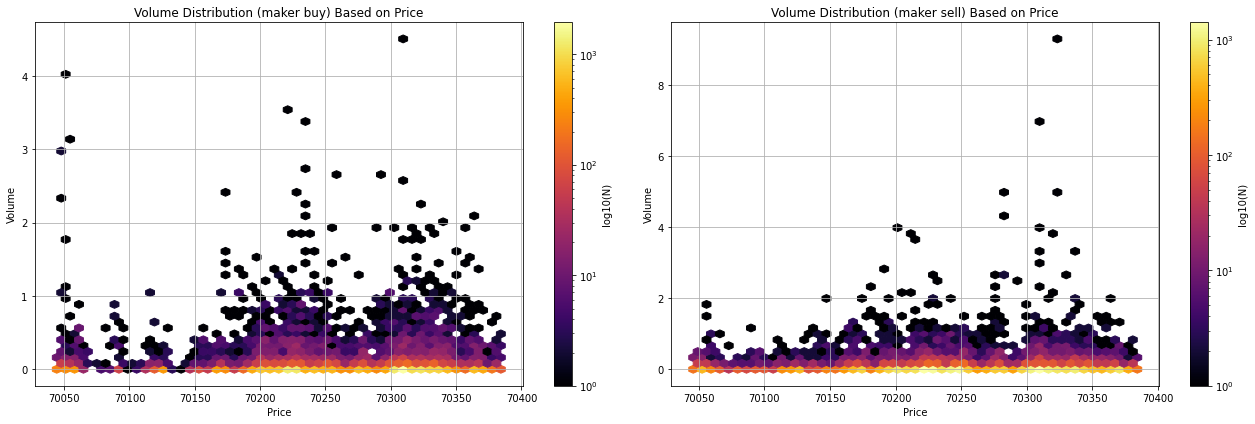

In [23]:

for trade_df in trades:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # First plot (maker buy)
    hb1 = ax1.hexbin(trade_df[trade_df['is_buyer_maker'] == True]['price'],
                     trade_df[trade_df['is_buyer_maker'] == True]['qty'],
                     gridsize=50, cmap='inferno', bins='log')
    cbar1 = fig.colorbar(hb1, ax=ax1, label='log10(N)')
    ax1.set_title('Volume Distribution (maker buy) Based on Price')
    ax1.set_xlabel('Price')
    ax1.set_ylabel('Volume')
    ax1.grid(True)

    # Second plot (maker sell)
    hb2 = ax2.hexbin(trade_df[trade_df['is_buyer_maker'] == False]['price'],
                     trade_df[trade_df['is_buyer_maker'] == False]['qty'],
                     gridsize=50, cmap='inferno', bins='log')
    cbar2 = fig.colorbar(hb2, ax=ax2, label='log10(N)')
    ax2.set_title('Volume Distribution (maker sell) Based on Price')
    ax2.set_xlabel('Price')
    ax2.set_ylabel('Volume')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
    break




In [10]:

#strategy
def indicator(data):
    return data

class t(Strategy):

    lossperc = 10
    profitperc = 10
    longcond = False
    shortcond = False
    cash = 100
    leverage = 10
    trade_size = 0.5
    initsize = 1 #cash*leverage*trade_size

    def init(self):
        #self.hlimit_rate = resample_apply('1H', indicator, self.data.limit_rate , name = 'h_limit_rate' , color = "red")
        self.r = self.I(indicator , self.data.limit_rate , name = 'limit_rate', color = "red")
        #self.mean_vol = self.I(indicator , self.data.mean_vol , name = 'mean_vol')
        #self.r = self.I(indicator , self.data.r , name = 'ratio')
    def next(self):

        price = self.data.Close[-1]
        
        if self.position.size == 0 :
            #self.initsize = self.equity*self.leverage*self.trade_size
        
        #long
            if ((1/self.r) > 1.2 ) : #and price < self.data.Open[-1]) :
                self.longcond = True

            if ( self.longcond and self.position.size == 0 ) :
                self.buy(limit = price, size = self.initsize , #np.floor(self.initsize / price) ,
                          sl = price*(1- self.lossperc/1000),
                          tp = price*(1+ self.profitperc/1000) )
                self.longcond = False

        #Short

            if (self.r > 1.2 ) : #and price > self.data.Open[-1] ) :
                self.shortcond = True

            if ( self.shortcond and self.position.size == 0 ) :
                self.sell(limit = price, size = self.initsize , #np.floor(self.initsize / price) ,
                          sl = price*(1+ self.lossperc/1000),
                          tp = price*(1- self.profitperc/1000) )
                self.shortcond = False

        else :
            pass

In [11]:
#backtesting
cash = 10000000 #100
leverage = 1#30
bt = Backtest(ohdftemp, t,
              cash = cash , margin = 1/leverage ,
              commission=0.0005, exclusive_orders= True)
output = bt.run()
print(output)

Start                     2024-04-12 00:00:00
End                       2024-04-12 23:30:00
Duration                      0 days 23:30:00
Exposure Time [%]                   52.083333
Equity Final [$]                10000598.4965
Equity Peak [$]                 10000598.4965
Return [%]                           0.005985
Buy & Hold Return [%]               -4.522552
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.009439
Avg. Drawdown [%]                   -0.009439
Max. Drawdown Duration        0 days 14:00:00
Avg. Drawdown Duration        0 days 14:00:00
# Trades                                    3
Win Rate [%]                        66.666667
Best Trade [%]                       0.950475
Worst Trade [%]                     -1.050525
Avg. Trade [%]                    

In [12]:
bt.plot()

Row(id='1474', ...)

In [ ]:
#list of trades
trades = output['_trades']
#trades.Size /= factor
#trades.EntryPrice *= factor
#trades.ExitPrice *= factor
table = tabulate(trades, headers='keys', tablefmt='fancy')
print(table)